In [23]:
# Import things
%matplotlib inline
import matplotlib
#matplotlib.use('Agg')

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as md
import pandas as pd
from matplotlib import rcParams
import os
import glob
from scipy import io

# Supress warnings for sake of log file
import warnings
warnings.filterwarnings("ignore")

# Plotting preferences

rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams.update({'font.size': 14}) 
rcParams['axes.titlepad'] = 14 
rcParams['xtick.major.pad']='10'
rcParams['ytick.major.pad']='10'
myFmt = md.DateFormatter('%H/%d')
rule = md.HourLocator(interval=12)

In [19]:
# Function to get just the last lines of a file

def tail( f, lines=20 ):
    total_lines_wanted = lines
    BLOCK_SIZE = 1024
    f.seek(0, 2)
    block_end_byte = f.tell()
    lines_to_go = total_lines_wanted
    block_number = -1
    blocks = [] # blocks of size BLOCK_SIZE, in reverse order starting
                # from the end of the file
    while lines_to_go > 0 and block_end_byte > 0:
        if (block_end_byte - BLOCK_SIZE > 0):
            # read the last block we haven't yet read
            f.seek(block_number*BLOCK_SIZE, 2)
            blocks.append(f.read(BLOCK_SIZE))
        else:
            # file too small, start from begining
            f.seek(0,0)
            # only read what was not read
            blocks.append(f.read(block_end_byte))
        lines_found = blocks[-1].count(b'\n')
        lines_to_go -= lines_found
        block_end_byte -= BLOCK_SIZE
        block_number -= 1
    all_read_text = b''.join(reversed(blocks))
    all_read_text = all_read_text.decode("utf-8")
    return '\n'.join(all_read_text.splitlines()[-total_lines_wanted:])

def get_opc(opc_n,d_loc,d1,d2):
    os.chdir(d_loc+'Data/')                  # Change directory to where the data is
    #log = open(log_licor,'w')             # Open the log file for writing
    all_files = glob.glob('*%s*OPC*'%opc_n)
    if opc_n=='TAWO':
        file_dates = np.asarray([(dt.datetime.strptime(f[-12:-4], '%Y%m%d')).date() for f in all_files])
    else:
        file_dates = np.asarray([(dt.datetime.strptime(f[-14:-4], '%Y-%m-%d')).date() for f in all_files])
           
    idxs = np.where(np.logical_and(file_dates>=d1.date(), file_dates<=d2.date()))[0]
    dfs = [all_files[i] for i in idxs]
    opc = pd.DataFrame()
    # Extract the data
    for f in dfs: 
        # Ignore file if it's empty
        if os.path.getsize(f)==0:
            #log.write('Error with: '+f+' this file is empty.\n')
            continue 
        opc = opc.append(pd.read_csv(f, skiprows=4,sep=',',error_bad_lines=False))  
    opc['Dates'] = pd.to_datetime(opc['time'],format='%Y-%m-%d %H:%M:%S')
    opc = opc.sort_values('Dates')
    opc = opc.set_index(opc['Dates'])
    opc.index = pd.DatetimeIndex(opc.index)
    #opc = opc[~opc.index.duplicated()]
    del opc['time'], opc['Dates']

    # Convert flow rate from L/min to cm3/s
    # 1 L/min = 16.66667 cm3/s
    opc.FlowRate = opc.FlowRate/100 * 16.66667

    # Get total counts
    opc['total_counts']=opc['b0'].astype(float)+ opc['b1'].astype(float)+ opc['b2'].astype(float)+ opc['b3'].astype(float)+ opc['b4'].astype(float)+ opc['b5'].astype(float)+ opc['b6'].astype(float)+ opc['b7'].astype(float)+ opc['b8'].astype(float)+ opc['b9'].astype(float)+ opc['b10'].astype(float)+ opc['b11'].astype(float)+ opc['b12'].astype(float)+ opc['b13'].astype(float)+ opc['b14'].astype(float)+ opc['b15'].astype(float)+ opc['b16'].astype(float)+ opc['b17'].astype(float)+ opc['b18'].astype(float)+ opc['b19'].astype(float)+ opc['b20'].astype(float)+ opc['b21'].astype(float)+ opc['b22'].astype(float)+ opc['b23'].astype(float)
    opc['total_counts']=opc['total_counts'].replace({0: np.nan})
    # Convert total counts/interval to total counts/s
    opc.period = opc.period/100 # period in s
    opc.total_counts = opc.total_counts /opc.period
    # Convert total counts/second to counts/cm3
    opc['OPC_conc'] = opc.total_counts / opc.FlowRate

    return opc

# Function to read and import GRIMM OPC data
def get_skyopc(d_loc,d1,d2):
    os.chdir(d_loc+'Data/')                  # Change directory to where the data is
    #log = open(log_licor,'w')             # Open the log file for writing
    all_files = glob.glob('*SKYOPC*')
    file_dates = np.asarray([(dt.datetime.strptime(f[-14:-4], '%Y-%m-%d')).date() for f in all_files])
    idxs = np.where(np.logical_and(file_dates>=d1.date(), file_dates<=d2.date()))[0]
    dfs = [all_files[i] for i in idxs]
    skyopc = pd.DataFrame()
    c=np.nan
    # Extract the data
    for f in dfs: 
        # Ignore file if it's empty
        if os.path.getsize(f)==0:
            #log.write('Error with: '+f+' this file is empty.\n')
            continue 
        f_data = open(f)
        d = f_data.readlines()
        f_data.close()
        for i in range(0,len(d)):
            line=d[i].split()
            if line[0] =='P':
                if len(line)!=17:
                    c=0
                    datetime=np.nan
                    continue
                #Year Mon Day Hr Min Loc 4Tmp Err pA/p pR/p UeL Ue4 Ue3 Ue2 Ue1 Iv 
                datetime = dt.datetime(int(line[1])+2000,int(line[2]),int(line[3]),int(line[4]),int(line[5]))
                #datetime = dt.datetime.strptime('20'+line[1]+line[2]+line[3]+line[4]+line[5],'%Y%m%d%H%M')
                quad_Tmp = int(line[7])
                Err = int(line[8])
                pAp = int(line[9])
                pRp = int(line[10])
                Int = int(line[16])
                c=0
            
            elif len(line)!=9:
                continue

            elif c==0: 
                ch1=int(line[1])
                ch2=int(line[2])
                ch3=int(line[3])
                ch4=int(line[4])
                ch5=int(line[5])
                ch6=int(line[6])
                ch7=int(line[7])
                ch8=int(line[8])
                c = c+1    
            elif c ==1:
                ch9=int(line[1])
                ch10=int(line[2])
                ch11=int(line[3])
                ch12=int(line[4])
                ch13=int(line[5])
                ch14=int(line[6])
                ch15=int(line[7])
                ch16=int(line[8])
                c = c+1
            elif c == 2:
                ch17=int(line[1])
                ch18=int(line[2])
                ch19=int(line[3])
                ch20=int(line[4])
                ch21=int(line[5])
                ch22=int(line[6])
                ch23=int(line[7])
                ch24 =int(line[8])
                c= c+1
            elif c==3:
                ch25=int(line[1])
                ch26=int(line[2])
                ch27=int(line[3])
                ch28=int(line[4])
                ch29=int(line[5])
                ch30=int(line[6])
                ch31=int(line[7])
                ch32=int(line[8])
                c = 0
                n = int(line[0][-2])
                if isinstance(datetime,dt.datetime):
                    skyopc = skyopc.append(pd.Series([datetime+dt.timedelta(seconds=n*6), ch1, ch2, ch3, ch4, ch5, ch6, ch7, ch8, ch9, ch10, ch11, ch12, ch13, ch14, ch15, ch16, ch17, ch18, ch19, ch20, ch21, ch22, ch23, ch24, ch25, ch26, ch27, ch28, ch29, ch30, ch31, ch32, quad_Tmp,Err,pAp,pRp,Int]),ignore_index=True)
            
    skyopc=skyopc.rename(columns={0: 'Date',1:'ch1' ,2: 'ch2', 3: 'ch3',4: 'ch4',5: 'ch5',6: 'ch6',7: 'ch7',8: 'ch8',9: 'ch9',10: 'ch10',11: 'ch11',12: 'ch12',13: 'ch13',14: 'ch14',15: 'ch15',16: 'ch16',17: 'ch17',18: 'ch18',19: 'ch19', 20:'ch20',21: 'ch21',22: 'ch22',23: 'ch23',24: 'ch24',25: 'ch25',26: 'ch26',27: 'ch27',28: 'ch28',29: 'ch29',30: 'ch30',31: 'ch31',32: 'ch32',33: 'quad_Tmp',34:'Err',35:'pAp',36:'pRp',37:'Int'})
    skyopc.dropna(inplace=True)
    skyopc = skyopc.set_index('Date')
    skyopc = skyopc.sort_values('Date')
    skyopc.index = pd.DatetimeIndex(skyopc.index)
    skyopc = skyopc[~skyopc.index.duplicated()]
    # remove repeated channel 16
    del skyopc['ch16']

    # Units: counts/100ml == 100 counts/cm3
    # Calculate total counts/cm3 by adding bins
    skyopc['SKYOPC_conc']=skyopc['ch1']+skyopc['ch2']+skyopc['ch3']+skyopc['ch4']+skyopc['ch5']+skyopc['ch6']+skyopc['ch7']+skyopc['ch8']+skyopc['ch9']+skyopc['ch10']+skyopc['ch11']+skyopc['ch12']+skyopc['ch13']+skyopc['ch14']+skyopc['ch15']+skyopc['ch17']+skyopc['ch18']+skyopc['ch19']+skyopc['ch20']+skyopc['ch21']+skyopc['ch22']+skyopc['ch23']+skyopc['ch24']+skyopc['ch25']+skyopc['ch26']+skyopc['ch27']+skyopc['ch28']+skyopc['ch29']+skyopc['ch30']+skyopc['ch31']+skyopc['ch32']
    skyopc['SKYOPC_conc']=skyopc['SKYOPC_conc']/100 #counts/cm3
    skyopc['SKYOPC_conc']=skyopc['SKYOPC_conc'].astype(float)
    
    return skyopc

# Function to read CPC data

def get_cpc(d_loc,d1,d2):
    os.chdir(d_loc+'Data/')                  # Change directory to where the data is
    #log = open(log_licor,'w')             # Open the log file for writing
    all_files = glob.glob('*CPC*')
    file_dates = np.asarray([(dt.datetime.strptime(f[11:-4], '%Y-%m-%d')).date() for f in all_files])
    idxs = np.where(np.logical_and(file_dates>=d1.date(), file_dates<=d2.date()))[0]
    dfs = [all_files[i] for i in idxs]
    cpc = pd.DataFrame()
    # Extract the data
    for f in dfs: 
    # Ignore file if it's empty
        if os.path.getsize(f)==0:
        #log.write('Error with: '+f+' this file is empty.\n')
            continue 
        cpc = cpc.append(pd.read_csv(f, header=None, sep=',',error_bad_lines=False))    

    cpc[0]= pd.to_numeric(cpc[0],errors='coerce')
    cpc[1]= pd.to_numeric(cpc[1],errors='coerce')
    cpc[2]= pd.to_numeric(cpc[2],errors='coerce')
    cpc[3]= pd.to_numeric(cpc[3],errors='coerce')
    cpc[4]= pd.to_numeric(cpc[4],errors='coerce')
    cpc[5]= pd.to_numeric(cpc[5],errors='coerce')
    cpc.dropna(inplace=True)
    cpc[5]=cpc[5].astype(int)
    cpc=cpc.rename(columns={0: "year", 1: "month", 2: "day", 3: "hour", 4: "minute", 5: "second"})
    cpc['Date'] = pd.to_datetime(cpc[['year', 'month', 'day', 'hour', 'minute','second']])
    cpc = cpc.set_index('Date')
    cpc['CPC_conc']=cpc[6] # Counts per cubic cm
    del cpc[6]
    cpc = cpc.sort_values('Date')
    cpc.index = pd.DatetimeIndex(cpc.index)
    #cpc = cpc[~cpc.index.duplicated()]
    cpc['CPC_conc']=cpc['CPC_conc'].astype(float) 
    
    return cpc



In [20]:
d_loc='/Users/heather/ICECAPS-ACE/temp_data/home/fluxtower/'
# Get plot times
d1 = dt.datetime(2019,8,5)
d2 = dt.datetime(2019,8,13)

MSF_OPC = get_opc('MSF',d_loc,d1,d2)
SKYOPC = get_skyopc(d_loc,d1,d2)
CPC = get_cpc(d_loc,d1,d2)

#CLASP = get_clasp(d_loc,yesterday,today,'CLASP_F',16,calfile,1)

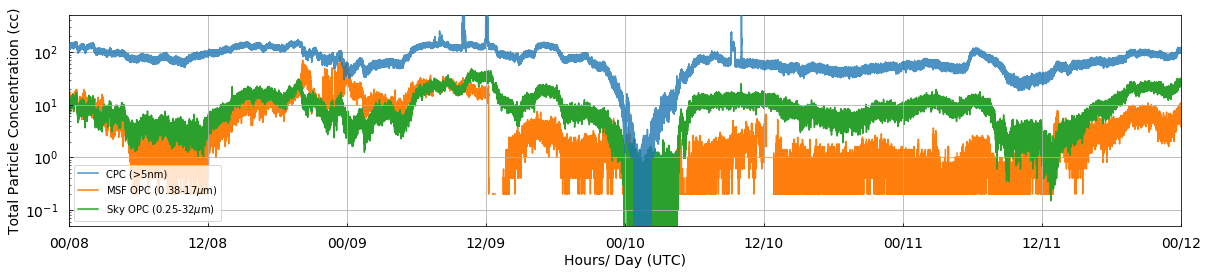

In [28]:

# Set up y lim
max_counts = max(cpc_count)
if max_counts<100:
    yulim = 100
else:
    yulim = max_counts+10

# Plot & save 
fig = plt.figure(figsize=(17,4))
ax = fig.add_subplot(111)
ax.grid(True)
ax.semilogy(CPC.index,CPC.CPC_conc, label='CPC (>5nm)',zorder=3,alpha=0.8)
ax.semilogy(MSF_OPC.index,MSF_OPC.total_counts,label = 'MSF OPC (0.38-17$\mu$m)',zorder=1)  
ax.semilogy(SKYOPC.index,SKYOPC.SKYOPC_conc,label = 'Sky OPC (0.25-32$\mu$m)',zorder=1)

ax.set_ylim(0,yulim)
ax.set_ylabel('Total Particle Concentration (cc)')
#ax.set_title('Total Particle Counts: %s'%((dt.datetime.strftime(d1,'%Y-%m-%d')+' to '+dt.datetime.strftime(d2,'%Y-%m-%d'))))
ax.set_xlabel('Hours/ Day (UTC)')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(rule)
ax.set_xlim(dt.datetime(2019,8,8),dt.datetime(2019,8,12))
ax.legend(loc='best',fontsize=10)
fig.tight_layout()
#fig.savefig(d_loc + 'Ncounts_current.png')
